In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
recom=pd.read_csv('/content/drive/MyDrive/MScProject/recommendation.csv')
recom.head()

,userId,productId,rating,timestamp
0,1,1,4.0,964982703
1,5,1,4.0,847434962
2,7,1,4.5,1106635946
3,15,1,2.5,1510577970
4,17,1,4.5,1305696483


In [ ]:
recom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19788 entries, 0 to 19787
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     19788 non-null  int64  
 1   productId  19788 non-null  int64  
 2   rating     19788 non-null  float64
 3   timestamp  19788 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 618.5 KB


In [ ]:

agg_ratings = recom.groupby('productId').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   productId          134 non-null    int64  
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 3.3 KB


In [ ]:

agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,productId,mean_rating,number_of_ratings
29,356,4.164134,329
25,318,4.429022,317
23,296,4.197068,307
49,593,4.161290,279
93,2571,4.192446,278


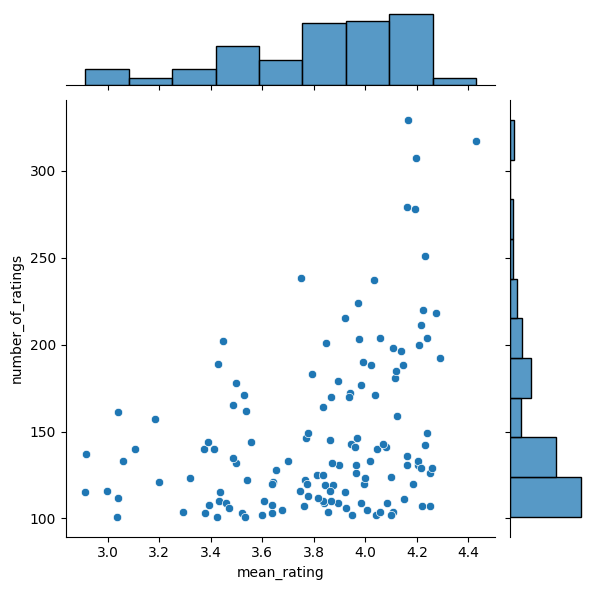

In [ ]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [ ]:
# Number of users
print('The ratings dataset has', recom['userId'].nunique(), 'unique users')


print('The ratings dataset has', recom['productId'].nunique(), 'unique product')


print('The ratings dataset has', recom['rating'].nunique(), 'unique ratings')

print('The unique ratings are', sorted(recom['rating'].unique()))

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [ ]:
# Create user-item matrix
matrix = recom.pivot_table(index='userId', columns='productId', values='rating')
matrix.head()

productId,1,2,6,10,32,34,39,47,50,110,...,7153,7361,7438,8961,33794,48516,58559,60069,68954,79132
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,NaN,NaN,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,4.5,NaN,NaN,4.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

productId,1,2,6,10,32,34,39,47,50,110,...,7153,7361,7438,8961,33794,48516,58559,60069,68954,79132
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.392857,NaN,-0.392857,NaN,NaN,NaN,NaN,0.607143,0.607143,-0.392857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.5,NaN,NaN,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,-1.382353,NaN,NaN,-1.382353,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.538462,NaN,NaN,NaN,NaN,0.538462,-0.461538,NaN,0.538462,0.538462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.391797,0.180151,-0.439941,-0.029894,0.464277,1.0,-0.037987,...,9.157371e-02,0.254514,0.101482,-0.500000,0.780020,0.303854,-0.012077,0.242309,-0.175412,0.071553
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-5.833333e-01,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-2.393249e-01,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,-4.532467e-17,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582


In [ ]:
# Pick a user ID
picked_userid = 1

# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-5.833333e-01,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,7.046689e-01,0.055442,NaN,0.360399,...,-2.393249e-01,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,3.288887e-01,0.030168,NaN,-0.777714,...,-4.532467e-17,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582
6,-0.439941,NaN,NaN,0.421927,-0.006888,1.000000,-7.323043e-18,-0.127385,NaN,0.957427,...,-2.927700e-01,-0.030599,-0.123983,-0.176327,0.063861,-0.468008,0.541386,-0.337129,0.158255,-0.030567


In [ ]:
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are userId
502    1.000000
598    1.000000
550    1.000000
108    1.000000
9      1.000000
401    0.942809
511    0.925820
366    0.872872
154    0.866025
595    0.866025
Name: 1, dtype: float64


In [ ]:
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

productId,1,6,47,50,110,223,231,260,296,316,...,2115,2329,2571,2628,2716,2858,2959,3147,3578,3793
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.392857,-0.392857,0.607143,0.607143,-0.392857,-1.392857,0.607143,0.607143,-1.392857,-1.392857,...,0.607143,0.607143,0.607143,-0.392857,0.607143,0.607143,0.607143,0.607143,0.607143,0.607143


In [ ]:
similar_user_pro = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_pro

productId,1,50,110,223,318,356,364,480,527,541,...,7153,7361,7438,8961,33794,48516,58559,60069,68954,79132
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,-0.666667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.533333,NaN,0.466667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,0.214286,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,0.214286
366,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.294118,NaN,-0.205882,-0.205882,-0.205882,0.294118,-0.205882,NaN,NaN,-0.205882
401,0.117647,NaN,NaN,NaN,NaN,0.117647,0.117647,NaN,NaN,NaN,...,-0.382353,NaN,NaN,0.617647,NaN,NaN,NaN,0.617647,0.617647,NaN
502,NaN,NaN,NaN,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,NaN,NaN,NaN,0.346154,-0.153846,NaN,NaN,0.346154,NaN,...,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.153846,0.346154
550,-0.277778,NaN,NaN,NaN,0.222222,-0.277778,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,-0.277778,0.222222,0.722222
595,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
similar_user_pro.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_pro

productId,318,364,541,588,589,595,1036,1704,1721,1968,...,7153,7361,7438,8961,33794,48516,58559,60069,68954,79132
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,0.466667,NaN,NaN,NaN,NaN,NaN,-0.533333,-0.533333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,0.214286
366,NaN,NaN,NaN,NaN,-0.205882,NaN,-0.205882,NaN,NaN,NaN,...,0.294118,NaN,-0.205882,-0.205882,-0.205882,0.294118,-0.205882,NaN,NaN,-0.205882
401,NaN,0.117647,NaN,-0.382353,NaN,-0.382353,NaN,NaN,NaN,NaN,...,-0.382353,NaN,NaN,0.617647,NaN,NaN,NaN,0.617647,0.617647,NaN
502,0.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.153846,0.346154
550,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,-0.277778,0.222222,0.722222
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_pro.columns:
  # Get the ratings for product i
  pro_rating = similar_user_pro[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the product has rating
    if pd.isna(pro_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the product rating
      score = similar_users[u] * pro_rating[u]
      # Add the score to the total score for the product so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['productID', 'pro_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='pro_score', ascending=False)

# Select top m product
m = 10
ranked_item_score.head(m)

,productID,pro_score
29,7361,1.888889
22,5816,1.888889
20,5418,0.888889
15,4963,0.888889
37,79132,0.587491
12,4878,0.466667
2,541,0.466667
18,4995,0.466667
33,48516,0.256727
0,318,0.222566
